# Bước 1: Import Modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: []


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bước 2: Load bộ dữ liệu NER

Thông tin các thực thể:

geo = Geographical Entity\
org = Organization\
per = Person\
gpe = Geopolitical Entity\
tim = Time indicator\
art = Artifact\
eve = Event\
nat = Natural Phenomenon

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Download(Win11)/ner_dataset.csv',encoding="latin1")
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu.
- Số lượng thẻ duy nhất trong tập dữ liệu.\
Bằng cách sử dụng hàm **“nunique”.**

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
print(words)
print(num_words)

['unto', 'indications', 'debt-to-GDP', 'district', 'honeycomb', 'famine-related', 'marshals', 'Rohrabacher', '11-year-old', 'single-most-important', 'Izzat', 'Alimport', 'mercantile', 'exporter', 'Forty-seven', 'slipping', 'recognized', '3,200-strong', '1,44,000', 'amputation', 'lamp', 'Baptist', 'produces', 'champions', 'Norway-based', 'irrigation', 'Indra', 'cheating', 'featuring', 'diving', 'Boulder', 'Mizuki', 'Saola', 'returning', 'Zone', 'Freeman', 'Jalani', 'idiot', 'Politician', 'writers', 'bared', 'Kaesong', 'league-wide', 'Zhou', "N'Djamena", 'land-use', 'precautions', 'Islamiah', 'Vassily', 'Downer', 'Trevor', 'Abkhaz', 'superiors', 're-started', '626', 'Al-Khashiban', 'PSV', 'Pinochet', 'Delivery', 'Saldanha', 'overborrowing', 'Yassin', 'Chimango', 'farewell', 'oil-producing', 'worldwide', 'whispered', 'Maulvi', '1946', 'co-exist', 'stepping', 'alike', 'Bauer', 'Vines', 'human-rights', 'bulky', 'Swords', 'stiffer', 'respondents', 'anti-corruption', 'Erekat', 'Transportation

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [ ]:
print(tags)
print(num_tags)

['I-geo', 'I-org', 'B-tim', 'I-tim', 'B-org', 'B-gpe', 'I-art', 'I-gpe', 'B-per', 'B-nat', 'O', 'I-eve', 'I-nat', 'B-geo', 'B-eve', 'B-art', 'I-per']
17


In [ ]:
print(num_words, num_tags)

35179 17


# Bước 3: Lấy các câu và các thẻ tương ứng

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
# word2idx
tag2idx 

{'B-art': 15,
 'B-eve': 14,
 'B-geo': 13,
 'B-gpe': 5,
 'B-nat': 9,
 'B-org': 4,
 'B-per': 8,
 'B-tim': 2,
 'I-art': 6,
 'I-eve': 11,
 'I-geo': 0,
 'I-gpe': 7,
 'I-nat': 12,
 'I-org': 1,
 'I-per': 16,
 'I-tim': 3,
 'O': 10}

Bước 5: Padding  đầu vào and cắt dữ liệu thành tập Train/Test\
Độ dài của câu trong tập dữ liệu khoảng 20 đến 22 dấu từ. Và trong trục X, có thể thấy giá trị an toàn là khoảng 50.

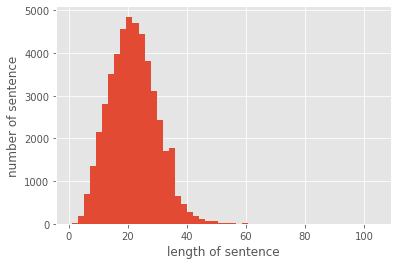

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
print(X[0])
print(y[0])

[13349  3480 18929 23942 18801 31685 23661 32998 15130  5989 19806 27162
 22115  2997   633  5989 18018  3480   977 31509  2001  7666 13885 25508
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[10 10 10 10 10 10 13 10 10 10 10 10 13 10 10 10 10 10  5 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Bước 6: Xây dựng Mô hình GRU-CNN (Bi-GRU + CNN)


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense,GRU,Conv1D
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam

In [ ]:

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = Conv1D(200,3,padding = "same",activation = "relu")(model)
model = Conv1D(200,4,padding = "same",activation = "relu")(model)
model = Conv1D(200,5,padding = "same",activation = "relu")(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.compile(optimizer=Adam(lr = 2e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          91200     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 50, 200)           120200    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 200)           160200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [ ]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=X,
    y=y,
    #validation_data=(x_,y_valid),
    validation_split= 0.05,
    batch_size= 128, 
    epochs=10,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/10
356/356 [==============================] - 198s 556ms/step - loss: 0.0474 - accuracy: 0.9858 - val_loss: 0.0418 - val_accuracy: 0.9874
Epoch 2/10
356/356 [==============================] - 199s 560ms/step - loss: 0.0408 - accuracy: 0.9877 - val_loss: 0.0356 - val_accuracy: 0.9892
Epoch 3/10
356/356 [==============================] - 200s 561ms/step - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.0323 - val_accuracy: 0.9902
Epoch 4/10
356/356 [==============================] - 200s 561ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0288 - val_accuracy: 0.9911
Epoch 5/10
356/356 [==============================] - 200s 561ms/step - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0265 - val_accuracy: 0.9919
Epoch 6/10
356/356 [==============================] - 200s 560ms/step - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.0249 - val_accuracy: 0.9923
Epoch 7/10
356/356 [==============================] - 199s 560ms/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 0.0232 -

# Bước8: Đánh giá mô hình NER


In [ ]:
score = model.evaluate(x_test, y_test, batch_size = 32, verbose = 1)
 
print('\nTest categorical_crossentropy:', score[0])
print('Categorical accuracy:', score[1])

300/300 [==============================] - 12s 39ms/step - loss: 0.0204 - accuracy: 0.9936

Test categorical_crossentropy: 0.020438922569155693
Categorical accuracy: 0.9936050772666931


- Dự đoán

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
Sudanese       B-gpe	B-gpe
government     O	O
has            O	O
welcomed       O	O
the            O	O
Chinese        B-gpe	B-gpe
mission        O	O
to             O	O
Darfur         O	B-geo
.              O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations        O	O
rations  

Yêu cầu:\
- Thêm đánh giá mô hình theo độ đo F1-score.
- Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.
- Lưu lại mô hình và bộ trọng số đã train.

# F1-score

In [ ]:
model.save_weights("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau1_GRUCNN_weight.h5")
model.save("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau1_GRUCNN.h5")

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis=-1)

y_predict = y_predict.reshape(1,-1)[0]
y_true = y_test.reshape(1,-1)[0]

entity_predict = [tags[i] for i in y_predict]
entity_true = [tags[i] for i in y_true]

report = classification_report(entity_true,entity_predict)

In [ ]:
print(report)

              precision    recall  f1-score   support

       B-art       1.00      0.09      0.17        96
       B-eve       0.75      0.42      0.54        79
       B-geo       0.91      0.96      0.94      7380
       B-gpe       0.98      0.95      0.96      3173
       B-nat       0.94      0.42      0.58        38
       B-org       0.89      0.85      0.87      3908
       B-per       0.93      0.92      0.93      3359
       B-tim       0.96      0.94      0.95      4102
       I-art       0.96      0.27      0.42        86
       I-eve       0.60      0.33      0.42        73
       I-geo       0.93      0.92      0.92      1449
       I-gpe       0.91      0.61      0.73        33
       I-nat       0.27      0.25      0.26        12
       I-org       0.92      0.93      0.93      3254
       I-per       0.91      0.97      0.94      3424
       I-tim       0.90      0.90      0.90      1339
           O       1.00      1.00      1.00    447795

    accuracy              